In [1]:
#Importing needed modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Loading csv file/creating df of relevant fields
x = input('Please type full file name (Note, this only works on files currently saved in Jupyter)  ')
car90 = pd.DataFrame(pd.read_csv(x)).rename(columns={'Unnamed: 0': 'MakeModel'})[['MakeModel','Price','Disp','Gear.Ratio','Gear2','Mileage','Reliability','HP','Weight','Type','Turning','Tires','Rim','Sratio.p','Sratio.m']]

Please type full file name (Note, this only works on files currently saved in Jupyter)  car90.csv


In [3]:
#Setting Up the df

#Reliability string to Int
car90.Reliability = [{'Much better': 5,'better': 4,'average': 3,'worse': 2,'Much worse': 1, np.nan: np.nan}[item] for item in car90.Reliability]

#Type string to Int
car90.Type = [{'Sporty': 6,'Small': 5,'Compact': 4,'Medium': 3,'Large': 2, 'Van': 1, np.nan: np.nan}[item] for item in car90.Type]

#Power-to-Weight Ratio
car90['Power_to_Weight'] = car90.apply(lambda x: (x.HP/x.Weight), axis = 1)

#Finding wheel dimensions
car90['TireWidth'] = pd.np.where(car90.Tires != car90.Tires, np.nan, pd.to_numeric(car90.Tires.str[:3]))
def AspectRatio(x):
    if x != x:
        return np.nan
    elif str(x)[-3] == '/':
        return int(str(x)[-2:])
    else:
        return int('100')
car90['TireAspectRatio'] = ((pd.DataFrame(car90.Tires.apply(AspectRatio)))/100)
car90['TireSideWall'] = car90.apply(lambda row: row[['TireAspectRatio']]*row['TireWidth'], axis=1)
car90['Rim'] = pd.np.where(car90.Rim != car90.Rim, np.nan, pd.to_numeric(car90.Rim.str[-2:]))
car90['TireDiameter'] = car90.apply(lambda row: (row[['Rim']]*25.4)+row['TireSideWall'], axis=1)

In [4]:
#Deriving Individual Z-Scores
car90Z = car90.drop(['MakeModel','Tires'],axis=1).apply(lambda x: ((x - np.nanmean(x))/np.nanstd(x)))

In [5]:
#Deriving Composite Z-Scores

car90Z['Gear_Comp'] = pd.to_numeric(car90Z[['Gear.Ratio','Gear2']].apply(lambda x: x['Gear.Ratio'] if x.Gear2 != x.Gear2 
                                                                     else(x.Gear2 if x['Gear.Ratio'] != x['Gear.Ratio'] 
                                                                                   else (x['Gear.Ratio']+x.Gear2)/2), axis=1))

car90Z['Steering_Comp'] = pd.to_numeric(car90Z[['Sratio.m','Sratio.p']].apply(lambda x: x['Sratio.m'] if x['Sratio.p'] != x['Sratio.p'] 
                                                                     else(x['Sratio.p'] if x['Sratio.m'] != x['Sratio.m'] 
                                                                                   else (x['Sratio.m']+x['Sratio.p'])/2), axis=1))


In [6]:
#Final Table Cleaning
car90Z['MakeModel'] = car90.MakeModel
car90Z.fillna(0,inplace=True)

In [7]:
#Calculate Multivariable Performance Scores

#Fuel_Efficiency
car90['Fuel_Efficiency'] = car90Z.apply(lambda x: -(x.Gear_Comp + x.Disp)/2 if x.Mileage == 0 else ((x.Mileage-((x.Gear_Comp + x.Disp)/2))/2), axis=1)

#Top_Speed--weighing HP, opposed to determining composite score
car90['Top_Speed'] = car90Z.apply(lambda x: x.HP + x.Type, axis=1)

#Handling
car90['Handling'] = car90Z.apply(lambda x: ((x.TireWidth - x.TireSideWall + x.TireDiameter)/3 - x.Steering_Comp - x.Turning)/3, axis=1)


In [8]:
#Convert MV Performance Scores to Z-Scores

car90P = car90[['Fuel_Efficiency','Top_Speed','Handling']]
car90P = car90P.apply(lambda x: ((x - np.mean(x))/np.std(x)))
car90Z[['Fuel_Efficiency','Top_Speed','Handling']] = car90P[['Fuel_Efficiency','Top_Speed','Handling']]

In [9]:
#Calculate Performance Score

car90Z['Performance'] = pd.DataFrame(car90Z.apply(lambda x: x.Fuel_Efficiency + x.Reliability + x.Power_to_Weight + x.Top_Speed + x.Handling, axis=1))


In [10]:
#Calculate Value and Determine Binning Thresholhds

car90Z['Value'] = (car90Z.apply(lambda x: x.Performance - x.Price, axis = 1))
car90Z = car90Z.sort_values(by=['Value'], ascending=True)
colorthreshold = car90Z.Value.quantile([0.333,0.666])

In [11]:
#Create Color Dictionary for Graphical Ranking

car90Z.loc[car90Z['Value'] > max(colorthreshold), 'Color'] = 'g' 
car90Z.loc[car90Z['Value'] <= max(colorthreshold), 'Color'] = 'y'
car90Z.loc[car90Z['Value'] < min(colorthreshold), 'Color'] = 'r'
car90Z.loc[car90Z['Price'] == 0, 'Color'] = 'r'

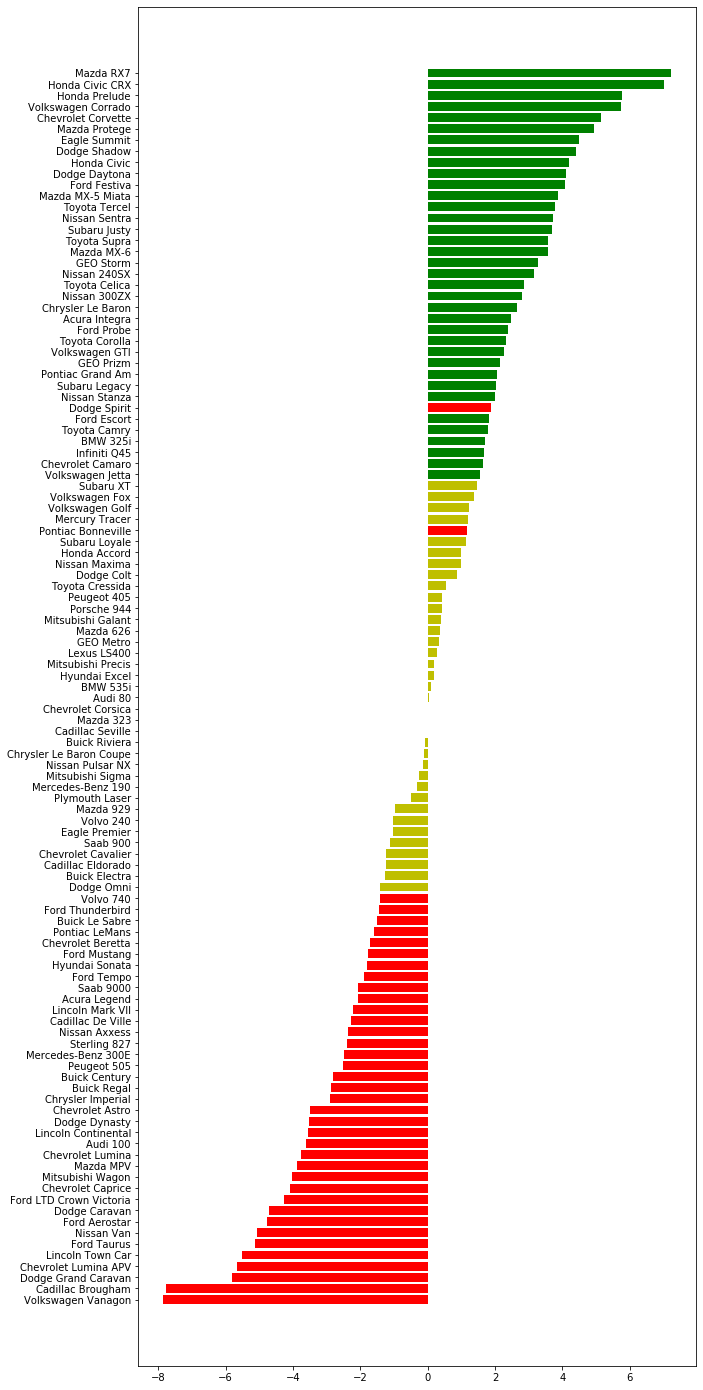

In [12]:
#Visualization

plt.rcParams['figure.figsize'] = [10, 25]
car90Z = car90Z.sort_values(by=['Value'],ascending=True)
plt.barh(car90Z.MakeModel, car90Z.Value, color=car90Z.Color)
plt.show()

In [13]:
#Export Final Output

car90Z.loc[car90Z['Value'] > max(colorthreshold), 'Rating'] = 'green' 
car90Z.loc[car90Z['Value'] <= max(colorthreshold), 'Rating'] = 'yellow'
car90Z.loc[car90Z['Value'] < min(colorthreshold), 'Rating'] = 'red'
car90Z.loc[car90Z['Price'] == 0, 'Rating'] = 'red'
car90Z[['MakeModel','Rating']].to_excel("RYGMakeModelRating.xlsx")